# **Modelling**

# Check for GPU

In [ ]:
import torch 

torch.cuda.is_available()

GPU is ready to be used

# Load Data

In [2]:
source = '../data/Rice_Leaf_AUG/Rice_Leaf_AUG'
train_dir = '../data/train'
val_dir = '../data/val'
test_dir = '../data/test'

In [ ]:
import tensorflow as tf

dataset = tf.keras.preprocessing.image_dataset_from_directory(

    source,
    validation_split=0,
    label_mode = 'int',
    seed=0,
    batch_size=None

)

Found 11790 files belonging to 9 classes.


# Get Class Names

In [4]:
class_names = dataset.class_names
print(f'Class names: {class_names}')

Class names: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Narrow Brown Leaf Spot', 'Neck_Blast', 'Rice Hispa', 'Sheath Blight']


# Data Preprocessing

In [5]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights

# Load base EfficientNet-B1 with pretrained weights
weights = EfficientNet_B1_Weights.DEFAULT
base_model = efficientnet_b1(weights=weights)


In [6]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_ds = ImageFolder(train_dir, transform=transform)
val_ds = ImageFolder(val_dir, transform=transform)
test_ds = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


# Model Creation

## Define model

In [7]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights

# Load pretrained EfficientNetB1 backbone
weights = EfficientNet_B1_Weights.DEFAULT
base_model = efficientnet_b1(weights=weights)

# Freeze base model if needed (like in your Keras model)
for param in base_model.parameters():
    param.requires_grad = False

# Replace the classifier
model = nn.Sequential(
    base_model.features,  # EfficientNetB1 without classification head
    nn.AdaptiveAvgPool2d(1),  # Global average pooling
    nn.Flatten(),  # Flatten to 1D
    nn.Linear(1280, 240),  # EfficientNetB1 output is 1280-dim
    nn.ReLU(),
    nn.Linear(240, 60),
    nn.ReLU(),
    nn.Linear(60, 30),
    nn.ReLU(),
    nn.Linear(30, 9),  # Your output classes
    nn.Softmax(dim=1)  # Matches Keras softmax
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Train model

In [9]:
# Number of epochs
num_epochs = 10  # Change this as needed

# Train the model
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over data in the training set
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch [1/10], Loss: 1.9057, Accuracy: 48.07%
Epoch [2/10], Loss: 1.7246, Accuracy: 65.15%
Epoch [3/10], Loss: 1.6838, Accuracy: 68.93%
Epoch [4/10], Loss: 1.6534, Accuracy: 71.84%
Epoch [5/10], Loss: 1.6361, Accuracy: 73.61%
Epoch [6/10], Loss: 1.6288, Accuracy: 74.32%
Epoch [7/10], Loss: 1.6121, Accuracy: 76.09%
Epoch [8/10], Loss: 1.5961, Accuracy: 77.63%
Epoch [9/10], Loss: 1.5902, Accuracy: 78.34%
Epoch [10/10], Loss: 1.5838, Accuracy: 78.87%


In [10]:
model.eval()  # Set the model to evaluation mode
val_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():  # No gradients needed for validation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Update statistics
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

# Calculate validation loss and accuracy
val_loss = val_loss / len(val_loader)
val_accuracy = 100 * val_correct / val_total
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Validation Loss: 1.5541, Validation Accuracy: 82.33%


In [11]:
# Evaluate on test set
model.eval()  # Set to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():  # No need to track gradients
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Final test metrics
test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 1.5519, Test Accuracy: 82.23%


In [12]:
torch.save(model.state_dict(), "efficientnet_b1_model.pth")

In [29]:
from zennit.composites import EpsilonGammaBox
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.attribution import Gradient
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
    

In [30]:
dataiter = iter(test_loader)
input_tensor, label = next(dataiter)
input_tensor = input_tensor.to(device)
label = label.to(device)  # Also move the label to the correct device
input_tensor.requires_grad = True

In [31]:
with composite.context(model):
    output = model(input_tensor)
    
    # Get the predicted class (target class)
    target_class = label[0]  # For single image (batch_size=1)
    
    # Zero out the previous gradients
    model.zero_grad()
    
    # Use the score for the target class (not the whole output)
    output[0, target_class].backward()  # Backpropagate using the specific class score

    # Now, get the relevance scores (gradients)
    relevance = input_tensor.grad.squeeze().detach().cpu().numpy()

In [33]:
print(relevance.shape)


(32, 3, 256, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


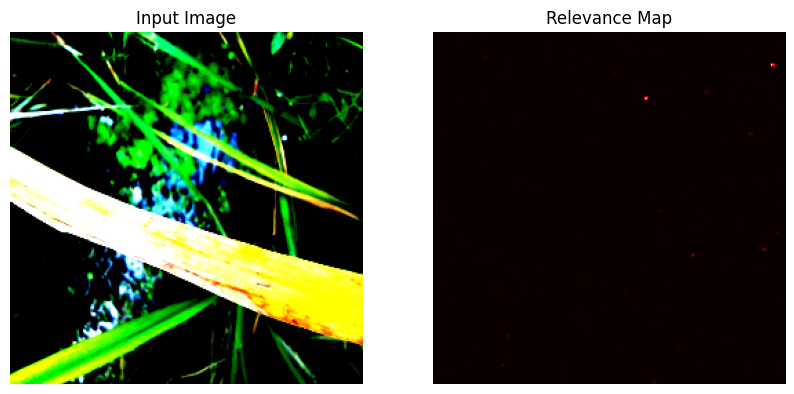

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming relevance has shape (32, 3, 256, 256)
# Select the first sample from the batch
relevance_sample = relevance[0]  # Shape will be (3, 256, 256)

# Sum the relevance across the 3 channels (for RGB images)
relevance_sum = np.sum(np.abs(relevance_sample), axis=0)  # Shape becomes (256, 256)

# Plot the image and the relevance map
plt.figure(figsize=(10, 5))

# Display the input image
plt.subplot(1, 2, 1)
input_image = input_tensor[0].detach().cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
plt.imshow(input_image)
plt.title("Input Image")
plt.axis('off')

# Display the relevance map
plt.subplot(1, 2, 2)
plt.imshow(relevance_sum, cmap='hot')
plt.title("Relevance Map")
plt.axis('off')

plt.show()
